# Forecast Reconciliation from Scratch in Python
Reconcile hierarchal forecasts into coherent forecasts using Python.

## Introduction
In my experience, it is somewhat unusual to work with real time-series data that does not have underlying "levels". For example, consider the data that might be produced via transactions at a grocery store. Transactions can be described at an individual product level, a shopper level, or at a store level. The products purchased might also be categorized into a specific type of product, and those categories might in turn fall into broader categories. For a business owner, this complex hierarchal structure can complicate making accurate and unbiased forecasts for their business. A data-driven person will most likely produce forecasts for each of the different levels, but they don't always add up. This is where reconciliation becomes necessary.

The majority of my explanations throughout this post are based on the book [*Forecasting: Principles and Practice*](https://otexts.com/fpp3/) by Rob J. Hyndman and George Athanasopoulos - an excellent resource for forecasting in general and completely free online. I highly recommend that you spend some time reading Hyndman's [more detailed explanation](https://otexts.com/fpp3/hierarchical.html) of reconciling hierarchal and grouped forecasts at some point. It is not my intention here to replace this book, although I still intend to give a comprehensive explanation of forecasting reconciliation. My intention in writing this blog-post is to provide whomever is reading this with the background needed to develop their own forecast reconciliation code. I have found that the [existing tools]() I have used are not (in my opinion) at a stage in their development where they can be considered reliable in a production environement, or cannot be generalized to every scenario (I know this from personal experience). I have also found that staring at a mathematical formula or applying some pre-defined function that somebody else created are not the best ways to gain a firm understanding of what is actually happening. Hopefully by sharing some short explanations of how one might go about writing their own Python code, I can also provide some additional insight that might not be attained otherwise.

## Hierarchal Time Series
To begin, I will give a brief introduction to the differences between hierarchal and grouped time series (no, they are not quite the same thing). A time series is considered *hierarchal*
when lower levels withing the hierarchy only fall under one domain. For example consider the following hierarchy tree:

In [13]:
from treelib import Tree

tree = Tree()
tree.create_node("Total", "total")  # root node
tree.create_node("Cat 1", "cat1", parent="total")
tree.create_node("Cat 2", "cat2", parent="total")
tree.create_node("SubCategory 1", "sub1", parent="cat1")
tree.create_node("SubCategory 2", "sub2", parent="cat1")
tree.create_node("SubCategory 3", "sub3", parent="cat2")
tree.create_node("SubCategory 4", "sub4", parent="cat2")
tree.create_node("SubCategory 5", "sub5", parent="cat2")
tree.show()

Total
├── Cat 1
│   ├── SubCategory 1
│   └── SubCategory 2
└── Cat 2
    ├── SubCategory 3
    ├── SubCategory 4
    └── SubCategory 5



`Sub-Category 1` falls exclusively under `Category 1`, `Sub-Category 4` falls exlusively under `Sub-Category 2`, etc. This *exclusivity* is what defines a hierarchal time series. It is also important to note that mathematically, each of the sub-categories should add up to the category above them, and `Total` is the total sum of each of the bottom-level categories. The mathematical expression looks like this:

*T* = *C1* + *C2* = *SC1* + *SC2* + *SC3* + *SC4* + *SC5* <br>
*C1* = *SC1* + *SC2* <br>
*C2* = *SC3* + *SC4* + *SC5* <br>

On the other hand, a *grouped* time series is when that exclusivity between sub-domains does not exist. For example, consider the same hierarchy tree but with only three sub-categories spread across each of the two primary categories:

In [2]:
tree = Tree()
tree.create_node("Total", "total")  # root node
tree.create_node("Category 1", "cat1", parent="total")
tree.create_node("Category 2", "cat2", parent="total")
tree.create_node("SubCategory 1", "sub1", parent="cat1")
tree.create_node("SubCategory 2", "sub2", parent="cat1")
tree.create_node("SubCategory 3", "sub3", parent="cat1")
tree.create_node("SubCategory 1", "sub4", parent="cat2")
tree.create_node("SubCategory 2", "sub5", parent="cat2")
tree.create_node("SubCategory 3", "sub6", parent="cat2")
tree.show()

Total
├── Category 1
│   ├── SubCategory 1
│   ├── SubCategory 2
│   └── SubCategory 3
└── Category 2
    ├── SubCategory 1
    ├── SubCategory 2
    └── SubCategory 3



The same hierarchy could also be described by the following tree:

In [3]:
tree = Tree()
tree.create_node("Total", "total")  # root node
tree.create_node("SubCategory 1", "sub1", parent="total")
tree.create_node("SubCategory 2", "sub2", parent="total")
tree.create_node("SubCategory 3", "sub3", parent="total")
tree.create_node("Category 1", "cat1", parent="sub1")
tree.create_node("Category 2", "cat2", parent="sub1")
tree.create_node("Category 1", "cat3", parent="sub2")
tree.create_node("Category 2", "cat4", parent="sub2")
tree.create_node("Category 1", "cat5", parent="sub3")
tree.create_node("Category 2", "cat6", parent="sub3")
tree.show()

Total
├── SubCategory 1
│   ├── Category 1
│   └── Category 2
├── SubCategory 2
│   ├── Category 1
│   └── Category 2
└── SubCategory 3
    ├── Category 1
    └── Category 2



This complexity of multiple arangements of the hierarchy groups means that the original formulas used are no longer valid. Hyndman [describes](https://otexts.com/fpp3/hts.html#grouped-time-series) this structural concept as *"not naturally disaggregat[ing] in a unique hierarchical manner."* 

The difference between hierarchal and grouped time series is important to understand, because the summing matrix (explained briefly in the next section) is dependent on the structure of the time series.

## Building-Blocks of Coherent Forecasts
Coherent - or *reconciled* - forecasts are constructed from a few key components:

**Base Forecasts:** <br>
Forecasts at each hierarchal level represented as an *m* x *n* matrix (*m* rows and *n* columns), where the columns of the matrix represent the hierarchal levels of the data and the rows represent each time period of the forecast horizon.

**Summing matrix:** <br>
The summing matrix describes the hierarchal/grouped structure of the data. For hierarchal summing matrices, the number of columns matches the number of unique categories on the bottom level. The number of rows is determined by the total number of unique categories across all levels. The values of the summing matrix are binary values that represent which bottom-level (column) categories map to each of the hierarchies across all levels. Consider the example shared previously of hierarchal data with two categories and five sub-categories. The summing matrix would look like the following:

In [16]:
import pandas as pd
pd.DataFrame(
    data = {
        'Sub-Category 1': [1,1,0,1,0,0,0,0],
        'Sub-Category 2': [1,1,0,0,1,0,0,0],
        'Sub-Category 3': [1,0,1,0,0,1,0,0],
        'Sub-Category 4': [1,0,1,0,0,0,1,0],
        'Sub-Category 5': [1,0,1,0,0,0,0,1]
        },
    index = [
        'Total', 'Category 1', 'Category 2', 
        'Cat 1 -> Sub-Cat 1', 
        'Cat 1 -> Sub-Cat 2',
        'Cat 2 -> Sub-Cat 3',
        'Cat 2 -> Sub-Cat 4',
        'Cat 2 -> Sub-Cat 5'
        ])

,Sub-Category 1,Sub-Category 2,Sub-Category 3,Sub-Category 4,Sub-Category 5
Total,1,1,1,1,1
Category 1,1,1,0,0,0
Category 2,0,0,1,1,1
Cat 1 -> Sub-Cat 1,1,0,0,0,0
Cat 1 -> Sub-Cat 2,0,1,0,0,0
Cat 2 -> Sub-Cat 3,0,0,1,0,0
Cat 2 -> Sub-Cat 4,0,0,0,1,0
Cat 2 -> Sub-Cat 5,0,0,0,0,1


Because grouped time series data does not disaggregate in a "unique manner," there is not one unique bottom level. This means that the summing matrix needs additional columns as well as additional rows. The grouped data from earlier in the post would look like this:

In [5]:
pd.DataFrame(
    data = {
        'Cat 1 / Sub-Cat 1': [1,1,0,1,0,0,1,0,0,0,0,0], 
        'Cat 1 / Sub-Cat 2': [1,1,0,0,1,0,0,1,0,0,0,0],
        'Cat 1 / Sub-Cat 3': [1,1,0,0,0,1,0,0,1,0,0,0],
        'Cat 2 / Sub-Cat 1': [1,0,1,1,0,0,0,0,0,1,0,0],
        'Cat 2 / Sub-Cat 2': [1,0,1,0,1,0,0,0,0,0,1,0],
        'Cat 2 / Sub-Cat 3': [1,0,1,0,0,1,0,0,0,0,0,1]
        },
    index = [
        'Total', 
        'Category 1', 
        'Category 2', 
        'Sub-Category 1',
        'Sub-Category 2',
        'Sub-Category 3',
        'Cat 1 / Sub-Cat 1', 
        'Cat 1 / Sub-Cat 2',
        'Cat 1 / Sub-Cat 3',
        'Cat 2 / Sub-Cat 1',
        'Cat 2 / Sub-Cat 2',
        'Cat 2 / Sub-Cat 3'
        ])

,Cat 1 / Sub-Cat 1,Cat 1 / Sub-Cat 2,Cat 1 / Sub-Cat 3,Cat 2 / Sub-Cat 1,Cat 2 / Sub-Cat 2,Cat 2 / Sub-Cat 3
Total,1,1,1,1,1,1
Category 1,1,1,1,0,0,0
Category 2,0,0,0,1,1,1
Sub-Category 1,1,0,0,1,0,0
Sub-Category 2,0,1,0,0,1,0
Sub-Category 3,0,0,1,0,0,1
Cat 1 / Sub-Cat 1,1,0,0,0,0,0
Cat 1 / Sub-Cat 2,0,1,0,0,0,0
Cat 1 / Sub-Cat 3,0,0,1,0,0,0
Cat 2 / Sub-Cat 1,0,0,0,1,0,0


**Mapping Matrix:** <br>
 The key componenent of forecast reconciliation is the mapping matrix. This matrix varies depending on the reconciliation method used, but the principle remains the same. When you multiply the mapping matrix with the summing and base forecast matrices (for either hierarchal or grouped time series), the result is a set of coherent forecasts. The challenge then is finding an "optimal" mapping matrix that can be used to reconcile the forecasts with the least amount of variance.

## Reconciliation Methods
Many different reconciliation methods exist, and some are better than others. I will not go into detail on the majority of them, but I will still list a few. Reconciliation methods fall under two categories: [single-level](https://otexts.com/fpp3/single-level.html) and [minimum trace](https://otexts.com/fpp3/reconciliation.html#the-mint-optimal-reconciliation-approach) methods. 

Some single-level methods include:
- Bottom-Up
- Top-Down
- Proportions of historical averages (method exists for proportions of historical actuals as well as historical forecasts)
- Middle-Out 

Some minimum trace methods include:
- Ordinary least squares (OLS)
- Weighted least squares (WLS) with variance scaling
- WLS with structrual scaling

For a more rigorous explanation of the different minimum trace methods - along with a few additional approaches - feel free to check out [this](https://robjhyndman.com/papers/mint.pdf) paper.

## Available Reconciliation Tools
As mentioned previously, there are a couple of existing tools/libraries that can apply the majority of reconciliation methods. The aforementioned Rob Hyndman helped to develop an R package called [`fabletools`](https://fabletools.tidyverts.org/reference/reconcile.html) that in my opinion is one of the best forecasting packages, and the best tool out there for forecast reconciliation. An effort is also underway to develop a Python package called [`scikit-hts`](https://scikit-hts.readthedocs.io/en/latest/readme.html). However, it is still pretty buggy and doesn't have all of the capabilities that exist in `fabletools`.

## Forecast Reconciliation in Python
I will not be sharing an explanation for coding all of the different methods available, nor will I be strictly showing all of the typical parts of machine learning (i.e. I won't be splitting data into training/test sets, generating forecasts, looking at accuracy metrics, etc.). My intention is to demonstrate how one might go about programming their own reconciliation algorithm, so I am going to be working with a sample dataset with pre-existing forecasts. <br>

Below are plots of each of the hierarchal levels in the sample dataset:

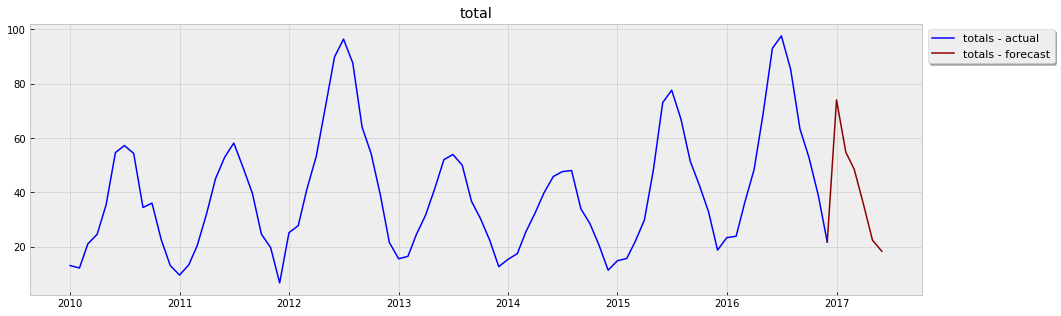

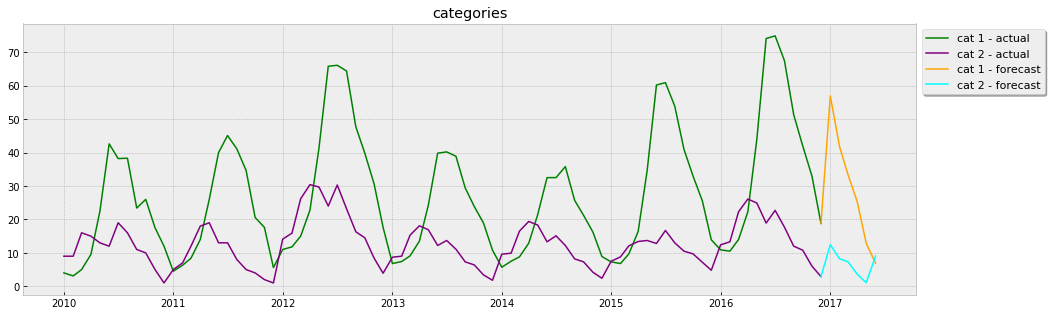

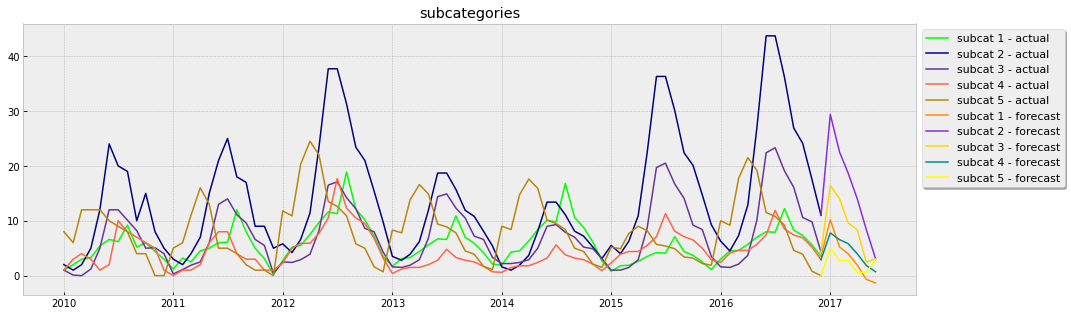

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('bmh')

df = pd.read_csv('../data/sample_hierarchal_data.csv').set_index('date')
df.index = pd.to_datetime(df.index).date 

def plot_hier(data, level='top'):
    fig, ax = plt.subplots(figsize=(16, 5))
    data['pred'] = ~data.actual
    data.loc[max(data.loc[(data.pred == False)].index), 'pred'] = True
    if level == 'top':
        l1, = ax.plot(data.loc[data.actual==True]['total'], lw=1.5, c='blue')
        l1.set_label(f'totals - actual')
        l2, = ax.plot(data.loc[data.pred==True]['total'], lw=1.5, c='darkred')
        l2.set_label('totals - forecast')
        ax.set_title('total')
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', shadow=True, prop={'size': 11})
    elif level == 'middle':
        l1, = ax.plot(data.loc[data.actual==True]['category_1'], lw=1.5, c='green')
        l1.set_label('cat 1 - actual')
        l2, = ax.plot(data.loc[data.actual==True]['category_2'], lw=1.5, c='purple')
        l2.set_label('cat 2 - actual')
        l3, = ax.plot(data.loc[data.pred==True]['category_1'], lw=1.5, c='orange')
        l3.set_label('cat 1 - forecast')
        l4, = ax.plot(data.loc[data.pred==True]['category_2'], lw=1.5, c='cyan')
        l4.set_label('cat 2 - forecast')
        ax.set_title('categories')
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', shadow=True, prop={'size': 11})
    elif level == 'bottom':
        l1, = ax.plot(data.loc[data.actual==True]['subcategory_1'], lw=1.5, c='lime')
        l1.set_label('subcat 1 - actual')
        l2, = ax.plot(data.loc[data.actual==True]['subcategory_2'], lw=1.5, c='navy')
        l2.set_label('subcat 2 - actual')
        l3, = ax.plot(data.loc[data.actual==True]['subcategory_3'], lw=1.5, c='rebeccapurple')
        l3.set_label('subcat 3 - actual')
        l4, = ax.plot(data.loc[data.actual==True]['subcategory_4'], lw=1.5, c='tomato')
        l4.set_label('subcat 4 - actual')
        l5, = ax.plot(data.loc[data.actual==True]['subcategory_5'], lw=1.5, c='darkgoldenrod')
        l5.set_label('subcat 5 - actual')

        l6, = ax.plot(data.loc[data.pred==True]['subcategory_1'], lw=1.5, c='darkorange')
        l6.set_label('subcat 1 - forecast')
        l7, = ax.plot(data.loc[data.pred==True]['subcategory_2'], lw=1.5, c='blueviolet')
        l7.set_label('subcat 2 - forecast')
        l8, = ax.plot(data.loc[data.pred==True]['subcategory_3'], lw=1.5, c='gold')
        l8.set_label('subcat 3 - forecast')
        l9, = ax.plot(data.loc[data.pred==True]['subcategory_4'], lw=1.5, c='darkcyan')
        l9.set_label('subcat 4 - forecast')
        l10, = ax.plot(data.loc[data.pred==True]['subcategory_5'], lw=1.5, c='yellow')
        l10.set_label('subcat 5 - forecast')
        ax.set_title('subcategories')
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', shadow=True, prop={'size': 11})
    else:
        raise ValueError('level must be "top", "middle", or "bottom"')

plot_hier(df, level='top')
plot_hier(df, level='middle')
plot_hier(df, level='bottom')

For this post, I will be demonstrating how to reconcile the forecasts using the Ordinary Least Squares Method. But the first steps are to define the Base Forecast Matrix and Summing Matrix:

In [ ]:
### TODO: Define Base Forecast Matrix and Summing Matrix

In [ ]:
### TODO: Define Mapping Matrix

In [ ]:
### TODO: OLS reconciliation

## References
[1] Rob J. Hyndman and George Athanasopoulos, *Forecasting: Principles and Practice 3rd ed.* (2022), https://otexts.com/fpp3/ <br>
[2] Shanika Wickramasuriya, George Athanasopoulos and Rob Hyndman; *Optimal Forecast Reconciliation for Hierarchical and Grouped Time Series through Trace Minimization* (2017); https://robjhyndman.com/papers/mint.pdf <br>
[3] Mitchell O'Hara-Wild, Rob Hyndman, Earo Wang; *fabletools* (2022); https://fabletools.tidyverts.org/reference/reconcile.html <br>
[4] Carlo Mazzaferro, *scikit-hts* (2019), https://scikit-hts.readthedocs.io/en/latest/readme.html